# Лабораторная работа 4

Tensorflow 2.x

1) Подготовка данных

2) Использование Keras Model API

3) Использование Keras Sequential + Functional API

https://www.tensorflow.org/tutorials

Для выполнения лабораторной работы необходимо установить tensorflow версии 2.0 или выше .

Рекомендуется использовать возможности Colab'а по обучению моделей на GPU.



In [ ]:
import os
import tensorflow as tf
import numpy as np
import math
import timeit
import matplotlib.pyplot as plt

%matplotlib inline

# Подготовка данных
Загрузите набор данных из предыдущей лабораторной работы.

In [ ]:
def load_mnist(num_training=49000, num_validation=1000, num_test=10000):
    """
    Fetch the CIFAR-10 dataset from the web and perform preprocessing to prepare
    it for the two-layer neural net classifier. These are the same steps as
    we used for the SVM, but condensed to a single function.
    """
    # Load the raw CIFAR-10 dataset and use appropriate data types and shapes
    mnist = tf.keras.datasets.mnist.load_data()
    (X_train, y_train), (X_test, y_test) = mnist
    X_train = np.asarray(X_train, dtype=np.float32)
    y_train = np.asarray(y_train, dtype=np.int32).flatten()
    X_test = np.asarray(X_test, dtype=np.float32)
    y_test = np.asarray(y_test, dtype=np.int32).flatten()

    # Subsample the data
    mask = range(num_training, num_training + num_validation)
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = range(num_training)
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = range(num_test)
    X_test = X_test[mask]
    y_test = y_test[mask]

    # Normalize the data: subtract the mean pixel and divide by std
    mean_pixel = X_train.mean(axis=(0, 1, 2), keepdims=True)
    std_pixel = X_train.std(axis=(0, 1, 2), keepdims=True)
    X_train = (X_train - mean_pixel) / std_pixel
    X_val = (X_val - mean_pixel) / std_pixel
    X_test = (X_test - mean_pixel) / std_pixel

    return X_train, y_train, X_val, y_val, X_test, y_test

# If there are errors with SSL downloading involving self-signed certificates,
# it may be that your Python version was recently installed on the current machine.
# See: https://github.com/tensorflow/tensorflow/issues/10779
# To fix, run the command: /Applications/Python\ 3.7/Install\ Certificates.command
#   ...replacing paths as necessary.

# Invoke the above function to get our data.
NHW = (0, 1, 2)
X_train, y_train, X_val, y_val, X_test, y_test = load_mnist()
X_train = X_train.reshape(-1, 28, 28, 1)
X_val = X_val.reshape(-1, 28, 28, 1)
X_test = X_test.reshape(-1, 28, 28, 1)
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape, y_train.dtype)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (49000, 28, 28, 1)
Train labels shape:  (49000,) int32
Validation data shape:  (1000, 28, 28, 1)
Validation labels shape:  (1000,)
Test data shape:  (10000, 28, 28, 1)
Test labels shape:  (10000,)


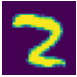

In [ ]:
import matplotlib.pyplot as plt
plt.figure(dpi = 20)
plt.imshow(X_train[28])
plt.axis("off")
plt.show()

In [ ]:
class Dataset(object):
    def __init__(self, X, y, batch_size, shuffle=False):
        """
        Construct a Dataset object to iterate over data X and labels y

        Inputs:
        - X: Numpy array of data, of any shape
        - y: Numpy array of labels, of any shape but with y.shape[0] == X.shape[0]
        - batch_size: Integer giving number of elements per minibatch
        - shuffle: (optional) Boolean, whether to shuffle the data on each epoch
        """
        assert X.shape[0] == y.shape[0], 'Got different numbers of data and labels'
        self.X, self.y = X, y
        self.batch_size, self.shuffle = batch_size, shuffle

    def __iter__(self):
        N, B = self.X.shape[0], self.batch_size
        idxs = np.arange(N)
        if self.shuffle:
            np.random.shuffle(idxs)
        return iter((self.X[i:i+B], self.y[i:i+B]) for i in range(0, N, B))


train_dset = Dataset(X_train, y_train, batch_size=64, shuffle=True)
val_dset = Dataset(X_val, y_val, batch_size=64, shuffle=False)
test_dset = Dataset(X_test, y_test, batch_size=64)

In [ ]:
# We can iterate through a dataset like this:
for t, (x, y) in enumerate(train_dset):
    print(t, x.shape, y.shape)
    if t > 5: break

0 (64, 28, 28, 1) (64,)
1 (64, 28, 28, 1) (64,)
2 (64, 28, 28, 1) (64,)
3 (64, 28, 28, 1) (64,)
4 (64, 28, 28, 1) (64,)
5 (64, 28, 28, 1) (64,)
6 (64, 28, 28, 1) (64,)


#  Keras Model Subclassing API


Для реализации собственной модели с помощью Keras Model Subclassing API необходимо выполнить следующие шаги:

1) Определить новый класс, который является наследником tf.keras.Model.

2) В методе __init__() определить все необходимые слои из модуля tf.keras.layer

3) Реализовать прямой проход в методе call() на основе слоев, объявленных в __init__()

Ниже приведен пример использования keras API для определения двухслойной полносвязной сети.

https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras

In [ ]:
# Для использования GPU 
USE_GPU = True

if USE_GPU:
    device = '/device:GPU:0'
else:
    device = '/cpu:0'

print('Using device: ', device)

Using device:  /device:GPU:0


In [ ]:
class TwoLayerFC(tf.keras.Model):
    def __init__(self, hidden_size, num_classes):
        super(TwoLayerFC, self).__init__()
        initializer = tf.initializers.VarianceScaling(scale=2.0)
        self.fc1 = tf.keras.layers.Dense(hidden_size, activation='relu',
                                   kernel_initializer=initializer)
        self.fc2 = tf.keras.layers.Dense(num_classes, activation='softmax',
                                   kernel_initializer=initializer)
        self.flatten = tf.keras.layers.Flatten()

    def call(self, x, training=False):
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.fc2(x)
        return x


def test_TwoLayerFC():
    """ A small unit test to exercise the TwoLayerFC model above. """
    input_size, hidden_size, num_classes = 50, 42, 10
    x = tf.zeros((64, input_size))
    model = TwoLayerFC(hidden_size, num_classes)
    with tf.device(device):
        scores = model(x)
        print(scores.shape)

test_TwoLayerFC()

(64, 10)


Реализуйте трехслойную CNN для вашей задачи классификации.

Архитектура сети:
    
1. Сверточный слой (5 x 5 kernels, zero-padding = 'same')
2. Функция активации ReLU
3. Сверточный слой (3 x 3 kernels, zero-padding = 'same')
4. Функция активации ReLU
5. Полносвязный слой
6. Функция активации Softmax

https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/layers/Conv2D

https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/layers/Dense

In [ ]:
class ThreeLayerConvNet(tf.keras.Model):
    def __init__(self, channel_1, channel_2, num_classes):
        super(ThreeLayerConvNet, self).__init__()
        ########################################################################
        # TODO: Implement the __init__ method for a three-layer ConvNet. You   #
        # should instantiate layer objects to be used in the forward pass.     #
        ########################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        # задаём как инициализируются веса
        initializer = tf.initializers.VarianceScaling(scale=2.0)
        self.flatten = tf.keras.layers.Flatten()
        # первый сверточный слой и активационная функция relu
        self.conv1 = tf.keras.layers.Conv2D(channel_1, [5,5], [1,1], padding='same',
                                            kernel_initializer=initializer,
                                            activation='relu')
        # второй сверточный слой и активационная функция relu
        self.conv2 = tf.keras.layers.Conv2D(channel_2, [3,3], [1,1], padding='same',
                                            kernel_initializer=initializer,
                                            activation='relu')
        # полносвязный слой и активационная функция softmax
        self.fc = tf.keras.layers.Dense(num_classes, activation='softmax', kernel_initializer=initializer)
        

        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        ########################################################################
        #                           END OF YOUR CODE                           #
        ########################################################################

    def call(self, x, training=False):
        scores = None
        ########################################################################
        # TODO: Implement the forward pass for a three-layer ConvNet. You      #
        # should use the layer objects defined in the __init__ method.         #
        ########################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        
        # задаём их порядок при проходе по сети
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.flatten(x)
        scores = self.fc(x)

        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        ########################################################################
        #                           END OF YOUR CODE                           #
        ########################################################################
        return scores

In [ ]:
def test_ThreeLayerConvNet():
    channel_1, channel_2, num_classes = 12, 8, 10
    model = ThreeLayerConvNet(channel_1, channel_2, num_classes)
    with tf.device(device):
        x = tf.zeros((64, 3, 32, 32))
        scores = model(x)
        print(scores.shape)

test_ThreeLayerConvNet()

(64, 10)


Пример реализации процесса обучения:

In [ ]:
def train_part34(model_init_fn, optimizer_init_fn, num_epochs=1, is_training=False):
    """
    Simple training loop for use with models defined using tf.keras. It trains
    a model for one epoch on the CIFAR-10 training set and periodically checks
    accuracy on the CIFAR-10 validation set.

    Inputs:
    - model_init_fn: A function that takes no parameters; when called it
      constructs the model we want to train: model = model_init_fn()
    - optimizer_init_fn: A function which takes no parameters; when called it
      constructs the Optimizer object we will use to optimize the model:
      optimizer = optimizer_init_fn()
    - num_epochs: The number of epochs to train for

    Returns: Nothing, but prints progress during trainingn
    """
    with tf.device(device):


        loss_fn = tf.keras.losses.SparseCategoricalCrossentropy()

        model = model_init_fn()
        optimizer = optimizer_init_fn()

        train_loss = tf.keras.metrics.Mean(name='train_loss')
        train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

        val_loss = tf.keras.metrics.Mean(name='val_loss')
        val_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='val_accuracy')

        t = 0
        for epoch in range(num_epochs):

            # Reset the metrics - https://www.tensorflow.org/alpha/guide/migration_guide#new-style_metrics
            train_loss.reset_states()
            train_accuracy.reset_states()

            for x_np, y_np in train_dset:
                with tf.GradientTape() as tape:

                    # Use the model function to build the forward pass.
                    scores = model(x_np, training=is_training)
                    loss = loss_fn(y_np, scores)

                    gradients = tape.gradient(loss, model.trainable_variables)
                    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

                    # Update the metrics
                    train_loss.update_state(loss)
                    train_accuracy.update_state(y_np, scores)

                    if t % print_every == 0:
                        val_loss.reset_states()
                        val_accuracy.reset_states()
                        for test_x, test_y in val_dset:
                            # During validation at end of epoch, training set to False
                            prediction = model(test_x, training=False)
                            t_loss = loss_fn(test_y, prediction)

                            val_loss.update_state(t_loss)
                            val_accuracy.update_state(test_y, prediction)

                        template = 'Iteration {}, Epoch {}, Loss: {}, Accuracy: {}, Val Loss: {}, Val Accuracy: {}'
                        print (template.format(t, epoch+1,
                                             train_loss.result(),
                                             train_accuracy.result()*100,
                                             val_loss.result(),
                                             val_accuracy.result()*100))
                    t += 1

In [ ]:
hidden_size, num_classes = 4000, 10
learning_rate = 1e-2

def model_init_fn():
    return TwoLayerFC(hidden_size, num_classes)

def optimizer_init_fn():
    return tf.keras.optimizers.SGD(learning_rate=learning_rate)

train_part34(model_init_fn, optimizer_init_fn)

Iteration 0, Epoch 1, Loss: 3.178163766860962, Accuracy: 12.5, Val Loss: 2.880155086517334, Val Accuracy: 18.700000762939453
Iteration 100, Epoch 1, Loss: 0.6502761244773865, Accuracy: 79.93502807617188, Val Loss: 0.5491976737976074, Val Accuracy: 81.69999694824219
Iteration 200, Epoch 1, Loss: 0.5115123987197876, Accuracy: 84.70926666259766, Val Loss: 0.4585873782634735, Val Accuracy: 85.9000015258789
Iteration 300, Epoch 1, Loss: 0.4506295621395111, Accuracy: 86.53966522216797, Val Loss: 0.41713929176330566, Val Accuracy: 86.5999984741211
Iteration 400, Epoch 1, Loss: 0.4059465825557709, Accuracy: 87.86237335205078, Val Loss: 0.37436404824256897, Val Accuracy: 89.0999984741211
Iteration 500, Epoch 1, Loss: 0.3827510178089142, Accuracy: 88.61963653564453, Val Loss: 0.3468128740787506, Val Accuracy: 90.10000610351562
Iteration 600, Epoch 1, Loss: 0.3594517409801483, Accuracy: 89.28607940673828, Val Loss: 0.348834365606308, Val Accuracy: 90.5999984741211
Iteration 700, Epoch 1, Loss: 0.

Обучите трехслойную CNN. В tf.keras.optimizers.SGD укажите Nesterov momentum = 0.9 .

https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/optimizers/SGD

Значение accuracy на валидационной выборке после 1 эпохи обучения должно быть > 50% .

In [ ]:
learning_rate = 3e-3
channel_1, channel_2, num_classes = 28, 14, 10

def model_init_fn():
    model = None
    ############################################################################
    # TODO: Complete the implementation of model_fn.                           #
    ############################################################################
    # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

    # создаём модель 
    model = ThreeLayerConvNet(channel_1, channel_2, num_classes)

    # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    ############################################################################
    #                           END OF YOUR CODE                               #
    ############################################################################
    return model

def optimizer_init_fn():
    optimizer = None
    ############################################################################
    # TODO: Complete the implementation of model_fn.                           #
    ############################################################################
    # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

    # задаём оптимизатор 
    optimizer = tf.keras.optimizers.SGD(learning_rate, 0.9, nesterov=True)

    # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    ############################################################################
    #                           END OF YOUR CODE                               #
    ############################################################################
    return optimizer

train_part34(model_init_fn, optimizer_init_fn)

Iteration 0, Epoch 1, Loss: 2.887362003326416, Accuracy: 15.625, Val Loss: 2.7359800338745117, Val Accuracy: 20.700000762939453
Iteration 100, Epoch 1, Loss: 0.4475470185279846, Accuracy: 86.47895812988281, Val Loss: 0.3676893413066864, Val Accuracy: 87.80000305175781
Iteration 200, Epoch 1, Loss: 0.3348863124847412, Accuracy: 90.08084869384766, Val Loss: 0.32356658577919006, Val Accuracy: 89.0999984741211
Iteration 300, Epoch 1, Loss: 0.27326348423957825, Accuracy: 91.87084197998047, Val Loss: 0.16036497056484222, Val Accuracy: 94.4000015258789
Iteration 400, Epoch 1, Loss: 0.2329058200120926, Accuracy: 93.04083251953125, Val Loss: 0.16865861415863037, Val Accuracy: 95.0
Iteration 500, Epoch 1, Loss: 0.21099543571472168, Accuracy: 93.73129272460938, Val Loss: 0.15520691871643066, Val Accuracy: 95.20000457763672
Iteration 600, Epoch 1, Loss: 0.1918870061635971, Accuracy: 94.33235931396484, Val Loss: 0.1722462773323059, Val Accuracy: 94.80000305175781
Iteration 700, Epoch 1, Loss: 0.177

# Использование Keras Sequential API для реализации последовательных моделей.

Пример для полносвязной сети:

In [ ]:
learning_rate = 1e-2

def model_init_fn():
    input_shape = (28, 28, 1)
    hidden_layer_size, num_classes = 4000, 10
    initializer = tf.initializers.VarianceScaling(scale=2.0)
    layers = [
        tf.keras.layers.Flatten(input_shape=input_shape),
        tf.keras.layers.Dense(hidden_layer_size, activation='relu',
                              kernel_initializer=initializer),
        tf.keras.layers.Dense(num_classes, activation='softmax',
                              kernel_initializer=initializer),
    ]
    model = tf.keras.Sequential(layers)
    return model

def optimizer_init_fn():
    return tf.keras.optimizers.SGD(learning_rate=learning_rate)

train_part34(model_init_fn, optimizer_init_fn)

Iteration 0, Epoch 1, Loss: 3.0605976581573486, Accuracy: 9.375, Val Loss: 2.459728479385376, Val Accuracy: 17.80000114440918
Iteration 100, Epoch 1, Loss: 0.6297723650932312, Accuracy: 80.92512512207031, Val Loss: 0.5358396768569946, Val Accuracy: 83.20000457763672
Iteration 200, Epoch 1, Loss: 0.5025713443756104, Accuracy: 85.07463073730469, Val Loss: 0.44012731313705444, Val Accuracy: 86.5999984741211
Iteration 300, Epoch 1, Loss: 0.44850730895996094, Accuracy: 86.64867401123047, Val Loss: 0.4204382300376892, Val Accuracy: 86.5999984741211
Iteration 400, Epoch 1, Loss: 0.40552788972854614, Accuracy: 88.00265502929688, Val Loss: 0.36974456906318665, Val Accuracy: 89.60000610351562
Iteration 500, Epoch 1, Loss: 0.38342562317848206, Accuracy: 88.68824768066406, Val Loss: 0.34171047806739807, Val Accuracy: 90.20000457763672
Iteration 600, Epoch 1, Loss: 0.3607070744037628, Accuracy: 89.32508087158203, Val Loss: 0.33536458015441895, Val Accuracy: 90.0
Iteration 700, Epoch 1, Loss: 0.3437

Альтернативный менее гибкий способ обучения:

In [ ]:
model = model_init_fn()
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=learning_rate),
              loss='sparse_categorical_crossentropy',
              metrics=[tf.keras.metrics.sparse_categorical_accuracy])
model.fit(X_train, y_train, batch_size=64, epochs=1, validation_data=(X_val, y_val))
model.evaluate(X_test, y_test)

313/313 [==============================] - 1s 2ms/step - loss: 0.2104 - sparse_categorical_accuracy: 0.9394


[0.21039751172065735, 0.9394000172615051]

Перепишите реализацию трехслойной CNN с помощью tf.keras.Sequential API . Обучите модель двумя способами.

In [ ]:
def model_init_fn():
    model = None
    ############################################################################
    # TODO: Construct a three-layer ConvNet using tf.keras.Sequential.         #
    ############################################################################
    # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

    input_shape = (28,28,1)
    channel_1, channel_2, num_classes = 28, 14, 10
    initializer = tf.initializers.VarianceScaling(scale=2.0)
    # создаём модель, только теперь сразу задаём порядок слоёв
    layers = [
        tf.keras.layers.Conv2D(channel_1, [5,5], [1,1], padding='same',
                               kernel_initializer=initializer,
                               activation='relu'),
        tf.keras.layers.Conv2D(channel_2, [3,3], [1,1], padding='same',
                               kernel_initializer=initializer,
                               activation='relu'),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(num_classes,
                              activation='softmax',
                              kernel_initializer=initializer)
    ]
    model = tf.keras.Sequential(layers)

    # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    ############################################################################
    #                            END OF YOUR CODE                              #
    ############################################################################
    return model

learning_rate = 5e-4
def optimizer_init_fn():
    optimizer = None
    ############################################################################
    # TODO: Complete the implementation of model_fn.                           #
    ############################################################################
    # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

    optimizer = tf.keras.optimizers.SGD(learning_rate, momentum=0.9, nesterov=True)

    # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    ############################################################################
    #                           END OF YOUR CODE                               #
    ############################################################################
    return optimizer

train_part34(model_init_fn, optimizer_init_fn)

Iteration 0, Epoch 1, Loss: 3.0814576148986816, Accuracy: 18.75, Val Loss: 2.755061388015747, Val Accuracy: 12.100000381469727
Iteration 100, Epoch 1, Loss: 0.6676200032234192, Accuracy: 79.7339096069336, Val Loss: 0.5117015242576599, Val Accuracy: 82.4000015258789
Iteration 200, Epoch 1, Loss: 0.5195857882499695, Accuracy: 84.2817153930664, Val Loss: 0.46267062425613403, Val Accuracy: 85.19999694824219
Iteration 300, Epoch 1, Loss: 0.4520604908466339, Accuracy: 86.27491760253906, Val Loss: 0.3340175747871399, Val Accuracy: 90.0
Iteration 400, Epoch 1, Loss: 0.40151551365852356, Accuracy: 87.83899688720703, Val Loss: 0.32256466150283813, Val Accuracy: 90.30000305175781
Iteration 500, Epoch 1, Loss: 0.3697809875011444, Accuracy: 88.85665893554688, Val Loss: 0.2788415849208832, Val Accuracy: 92.0999984741211
Iteration 600, Epoch 1, Loss: 0.3428543508052826, Accuracy: 89.6838607788086, Val Loss: 0.28889036178588867, Val Accuracy: 90.5999984741211
Iteration 700, Epoch 1, Loss: 0.3222733438

In [ ]:
model = model_init_fn()
model.compile(optimizer='sgd',
              loss='sparse_categorical_crossentropy',
              metrics=[tf.keras.metrics.sparse_categorical_accuracy])
model.fit(X_train, y_train, batch_size=64, epochs=1, validation_data=(X_val, y_val))

model.evaluate(X_test, y_test)

313/313 [==============================] - 1s 3ms/step - loss: 0.1011 - sparse_categorical_accuracy: 0.9688


[0.10114999860525131, 0.9688000082969666]

# Использование Keras Functional API

Для реализации более сложных архитектур сети с несколькими входами/выходами, повторным использованием слоев, "остаточными" связями (residual connections) необходимо явно указать входные и выходные тензоры.

Ниже представлен пример для полносвязной сети.

In [ ]:
def two_layer_fc_functional(input_shape, hidden_size, num_classes):
    initializer = tf.initializers.VarianceScaling(scale=2.0)
    inputs = tf.keras.Input(shape=input_shape)
    flattened_inputs = tf.keras.layers.Flatten()(inputs)
    fc1_output = tf.keras.layers.Dense(hidden_size, activation='relu',
                                 kernel_initializer=initializer)(flattened_inputs)
    scores = tf.keras.layers.Dense(num_classes, activation='softmax',
                             kernel_initializer=initializer)(fc1_output)

    # Instantiate the model given inputs and outputs.
    model = tf.keras.Model(inputs=inputs, outputs=scores)
    return model

def test_two_layer_fc_functional():
    """ A small unit test to exercise the TwoLayerFC model above. """
    input_size, hidden_size, num_classes = 50, 42, 10
    input_shape = (50,)

    x = tf.zeros((64, input_size))
    model = two_layer_fc_functional(input_shape, hidden_size, num_classes)

    with tf.device(device):
        scores = model(x)
        print(scores.shape)

test_two_layer_fc_functional()

(64, 10)


In [ ]:
input_shape = (28, 28, 1)
hidden_size, num_classes = 4000, 10
learning_rate = 1e-2

def model_init_fn():
    return two_layer_fc_functional(input_shape, hidden_size, num_classes)

def optimizer_init_fn():
    return tf.keras.optimizers.SGD(learning_rate=learning_rate)

train_part34(model_init_fn, optimizer_init_fn)

Iteration 0, Epoch 1, Loss: 2.972747802734375, Accuracy: 15.625, Val Loss: 2.5733275413513184, Val Accuracy: 25.899999618530273
Iteration 100, Epoch 1, Loss: 0.6422700881958008, Accuracy: 80.29084014892578, Val Loss: 0.5416250228881836, Val Accuracy: 83.0999984741211
Iteration 200, Epoch 1, Loss: 0.5097734928131104, Accuracy: 84.8103256225586, Val Loss: 0.45691603422164917, Val Accuracy: 86.19999694824219
Iteration 300, Epoch 1, Loss: 0.4524313509464264, Accuracy: 86.48774719238281, Val Loss: 0.4177607297897339, Val Accuracy: 87.5999984741211
Iteration 400, Epoch 1, Loss: 0.4089885652065277, Accuracy: 87.86627197265625, Val Loss: 0.37110236287117004, Val Accuracy: 89.20000457763672
Iteration 500, Epoch 1, Loss: 0.38532134890556335, Accuracy: 88.61963653564453, Val Loss: 0.35569119453430176, Val Accuracy: 90.20000457763672
Iteration 600, Epoch 1, Loss: 0.362491637468338, Accuracy: 89.27308654785156, Val Loss: 0.3431010842323303, Val Accuracy: 90.5999984741211
Iteration 700, Epoch 1, Los

Поэкспериментируйте с архитектурой сверточной сети. Для вашего набора данных вам необходимо получить как минимум 70% accuracy на валидационной выборке за 10 эпох обучения. Опишите все эксперименты и сделайте выводы (без выполнения данного пункта работы приниматься не будут).

Эспериментируйте с архитектурой, гиперпараметрами, функцией потерь, регуляризацией, методом оптимизации.  

https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/layers/BatchNormalization#methods https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/layers/Dropout#methods

In [ ]:
class CustomConvNet_B_and_D(tf.keras.Model):
    def __init__(self):
        super(CustomConvNet_B_and_D, self).__init__()
        ############################################################################
        # TODO: Construct a model that performs well on CIFAR-10                   #
        ############################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        channel_1, channel_2, num_classes = 28, 14, 10
        dp_rate = 0.2
        initializer = tf.initializers.VarianceScaling(scale=2.0)
        self.conv1 = tf.keras.layers.Conv2D(channel_1, [3,3], [1,1], padding='same',
                                  kernel_initializer=initializer)
        self.bn1 = tf.keras.layers.BatchNormalization()
        self.relu1 = tf.keras.layers.ReLU()
        self.dp1 = tf.keras.layers.Dropout(rate=dp_rate)
        self.conv2 = tf.keras.layers.Conv2D(channel_2, [3,3], [1,1], padding='same',
                                  kernel_initializer=initializer)
        self.bn2 = tf.keras.layers.BatchNormalization()
        self.relu2 = tf.keras.layers.ReLU()
        self.dp2 = tf.keras.layers.Dropout(rate=dp_rate)
        self.fl = tf.keras.layers.Flatten()
        self.fc = tf.keras.layers.Dense(num_classes,
                                  activation='softmax',
                                  kernel_initializer=initializer)

        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        ############################################################################
        #                            END OF YOUR CODE                              #
        ############################################################################

    def call(self, input_tensor, training=False):
        ############################################################################
        # TODO: Construct a model that performs well on CIFAR-10                   #
        ############################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        x = input_tensor
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.dp1(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.dp2(x)

        x = self.fl(x)
        x = self.fc(x)

        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        ############################################################################
        #                            END OF YOUR CODE                              #
        ############################################################################
        return x

In [ ]:
print_every = 500
num_epochs = 10

def model_init_fn():
    return CustomConvNet_B_and_D()

def optimizer_init_fn():
    learning_rate = 1e-3
    return tf.keras.optimizers.Adam(learning_rate)

train_part34(model_init_fn, optimizer_init_fn, num_epochs=num_epochs, is_training=True)

Iteration 0, Epoch 1, Loss: 2.81795072555542, Accuracy: 12.5, Val Loss: 3.44238018989563, Val Accuracy: 13.0
Iteration 500, Epoch 1, Loss: 0.2895374298095703, Accuracy: 91.07098388671875, Val Loss: 0.1784411370754242, Val Accuracy: 94.5999984741211
Iteration 1000, Epoch 2, Loss: 0.10361422598361969, Accuracy: 96.80850982666016, Val Loss: 0.1299298107624054, Val Accuracy: 95.20000457763672
Iteration 1500, Epoch 2, Loss: 0.08859823644161224, Accuracy: 97.28528594970703, Val Loss: 0.13115791976451874, Val Accuracy: 95.9000015258789
Iteration 2000, Epoch 3, Loss: 0.06556376069784164, Accuracy: 98.00772857666016, Val Loss: 0.10865584760904312, Val Accuracy: 96.0
Iteration 2500, Epoch 4, Loss: 0.058869868516922, Accuracy: 98.2681655883789, Val Loss: 0.11121949553489685, Val Accuracy: 96.69999694824219
Iteration 3000, Epoch 4, Loss: 0.05121024698019028, Accuracy: 98.3863754272461, Val Loss: 0.11465171724557877, Val Accuracy: 96.9000015258789
Iteration 3500, Epoch 5, Loss: 0.04014897719025612,

In [ ]:
def model_init_fn():
    return CustomConvNet_B_and_D()

def optimizer_init_fn():
    learning_rate = 1e-4
    return tf.keras.optimizers.Adam(learning_rate)

train_part34(model_init_fn, optimizer_init_fn, num_epochs=num_epochs, is_training=True)

Iteration 0, Epoch 1, Loss: 3.0820937156677246, Accuracy: 7.8125, Val Loss: 2.931793689727783, Val Accuracy: 11.90000057220459
Iteration 500, Epoch 1, Loss: 0.5849037170410156, Accuracy: 81.63672637939453, Val Loss: 0.3478394150733948, Val Accuracy: 90.10000610351562
Iteration 1000, Epoch 2, Loss: 0.24084007740020752, Accuracy: 92.7726058959961, Val Loss: 0.2583177387714386, Val Accuracy: 92.0
Iteration 1500, Epoch 2, Loss: 0.2022852897644043, Accuracy: 94.02210998535156, Val Loss: 0.1856543868780136, Val Accuracy: 94.30000305175781
Iteration 2000, Epoch 3, Loss: 0.1340954452753067, Accuracy: 96.18203735351562, Val Loss: 0.1579604595899582, Val Accuracy: 94.5999984741211
Iteration 2500, Epoch 4, Loss: 0.10674313455820084, Accuracy: 96.85960388183594, Val Loss: 0.13616518676280975, Val Accuracy: 95.0999984741211
Iteration 3000, Epoch 4, Loss: 0.0983617901802063, Accuracy: 97.1083755493164, Val Loss: 0.11497814208269119, Val Accuracy: 96.30000305175781
Iteration 3500, Epoch 5, Loss: 0.07

In [ ]:
def model_init_fn():
    return CustomConvNet_B_and_D()

def optimizer_init_fn():
    learning_rate = 1e-3
    return tf.keras.optimizers.SGD(learning_rate)

train_part34(model_init_fn, optimizer_init_fn, num_epochs=num_epochs, is_training=True)

Iteration 0, Epoch 1, Loss: 2.9370367527008057, Accuracy: 7.8125, Val Loss: 2.8018486499786377, Val Accuracy: 11.800000190734863
Iteration 500, Epoch 1, Loss: 0.8407033681869507, Accuracy: 73.82422637939453, Val Loss: 0.49360814690589905, Val Accuracy: 86.0
Iteration 1000, Epoch 2, Loss: 0.39733263850212097, Accuracy: 88.34441375732422, Val Loss: 0.4039209187030792, Val Accuracy: 88.80000305175781
Iteration 1500, Epoch 2, Loss: 0.37077438831329346, Accuracy: 89.05612182617188, Val Loss: 0.3583632707595825, Val Accuracy: 89.80000305175781
Iteration 2000, Epoch 3, Loss: 0.3108516037464142, Accuracy: 90.92484283447266, Val Loss: 0.3232205808162689, Val Accuracy: 91.19999694824219
Iteration 2500, Epoch 4, Loss: 0.2683602571487427, Accuracy: 92.11822509765625, Val Loss: 0.29799073934555054, Val Accuracy: 91.5
Iteration 3000, Epoch 4, Loss: 0.26287853717803955, Accuracy: 92.27640533447266, Val Loss: 0.27856990694999695, Val Accuracy: 91.9000015258789
Iteration 3500, Epoch 5, Loss: 0.23463620

In [ ]:
class CustomConvNet(tf.keras.Model):
    def __init__(self):
        super(CustomConvNet, self).__init__()
        ############################################################################
        # TODO: Construct a model that performs well on CIFAR-10                   #
        ############################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        channel_1, channel_2, num_classes = 28, 14, 10
        dp_rate = 0.2
        initializer = tf.initializers.VarianceScaling(scale=2.0)
        self.conv1 = tf.keras.layers.Conv2D(channel_1, [3,3], [1,1], padding='same',
                                  kernel_initializer=initializer)
        self.relu1 = tf.keras.layers.ReLU()
        self.conv2 = tf.keras.layers.Conv2D(channel_2, [3,3], [1,1], padding='same',
                                  kernel_initializer=initializer)
        self.relu2 = tf.keras.layers.ReLU()
        self.fl = tf.keras.layers.Flatten()
        self.fc = tf.keras.layers.Dense(num_classes,
                                  activation='softmax',
                                  kernel_initializer=initializer)

        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        ############################################################################
        #                            END OF YOUR CODE                              #
        ############################################################################

    def call(self, input_tensor, training=False):
        ############################################################################
        # TODO: Construct a model that performs well on CIFAR-10                   #
        ############################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        x = input_tensor
        x = self.conv1(x)
        x = self.relu1(x)

        x = self.conv2(x)
        x = self.relu2(x)

        x = self.fl(x)
        x = self.fc(x)

        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        ############################################################################
        #                            END OF YOUR CODE                              #
        ############################################################################
        return x

In [ ]:
print_every = 500
num_epochs = 10

def model_init_fn():
    return CustomConvNet()

def optimizer_init_fn():
    learning_rate = 1e-3
    return tf.keras.optimizers.Adam(learning_rate)

train_part34(model_init_fn, optimizer_init_fn, num_epochs=num_epochs, is_training=True)

Iteration 0, Epoch 1, Loss: 2.9499738216400146, Accuracy: 17.1875, Val Loss: 3.2266273498535156, Val Accuracy: 19.0
Iteration 500, Epoch 1, Loss: 0.19944646954536438, Accuracy: 94.04627990722656, Val Loss: 0.15643757581710815, Val Accuracy: 95.0
Iteration 1000, Epoch 2, Loss: 0.06698805838823318, Accuracy: 97.83245086669922, Val Loss: 0.11396176367998123, Val Accuracy: 96.20000457763672
Iteration 1500, Epoch 2, Loss: 0.05784729868173599, Accuracy: 98.18877410888672, Val Loss: 0.09511176496744156, Val Accuracy: 96.5
Iteration 2000, Epoch 3, Loss: 0.03456834331154823, Accuracy: 98.91058349609375, Val Loss: 0.12188944220542908, Val Accuracy: 96.20000457763672
Iteration 2500, Epoch 4, Loss: 0.025336775928735733, Accuracy: 99.15332794189453, Val Loss: 0.11148454993963242, Val Accuracy: 97.19999694824219
Iteration 3000, Epoch 4, Loss: 0.02267078123986721, Accuracy: 99.21319580078125, Val Loss: 0.11199691146612167, Val Accuracy: 97.0
Iteration 3500, Epoch 5, Loss: 0.02141137793660164, Accurac

In [ ]:
def model_init_fn():
    return CustomConvNet()

def optimizer_init_fn():
    learning_rate = 1e-4
    return tf.keras.optimizers.Adam(learning_rate)

train_part34(model_init_fn, optimizer_init_fn, num_epochs=num_epochs, is_training=True)

Iteration 0, Epoch 1, Loss: 3.05732798576355, Accuracy: 12.5, Val Loss: 2.7515642642974854, Val Accuracy: 10.800000190734863
Iteration 500, Epoch 1, Loss: 0.4411048889160156, Accuracy: 86.7203140258789, Val Loss: 0.25927793979644775, Val Accuracy: 92.79999542236328
Iteration 1000, Epoch 2, Loss: 0.1416395902633667, Accuracy: 95.81781768798828, Val Loss: 0.16844427585601807, Val Accuracy: 94.70000457763672
Iteration 1500, Epoch 2, Loss: 0.1193961501121521, Accuracy: 96.50935363769531, Val Loss: 0.15525172650814056, Val Accuracy: 94.5
Iteration 2000, Epoch 3, Loss: 0.08122418075799942, Accuracy: 97.68123626708984, Val Loss: 0.14936621487140656, Val Accuracy: 94.70000457763672
Iteration 2500, Epoch 4, Loss: 0.0645400658249855, Accuracy: 98.02955627441406, Val Loss: 0.13093501329421997, Val Accuracy: 95.20000457763672
Iteration 3000, Epoch 4, Loss: 0.060318171977996826, Accuracy: 98.266357421875, Val Loss: 0.10893337428569794, Val Accuracy: 96.0
Iteration 3500, Epoch 5, Loss: 0.04853532463

In [ ]:
def model_init_fn():
    return CustomConvNet()

def optimizer_init_fn():
    learning_rate = 1e-3
    return tf.keras.optimizers.SGD(learning_rate)

train_part34(model_init_fn, optimizer_init_fn, num_epochs=num_epochs, is_training=True)

Iteration 0, Epoch 1, Loss: 3.007843255996704, Accuracy: 9.375, Val Loss: 2.8182427883148193, Val Accuracy: 7.699999809265137
Iteration 500, Epoch 1, Loss: 0.6074138879776001, Accuracy: 81.96419525146484, Val Loss: 0.434714674949646, Val Accuracy: 86.69999694824219
Iteration 1000, Epoch 2, Loss: 0.29912322759628296, Accuracy: 91.40957641601562, Val Loss: 0.37025579810142517, Val Accuracy: 89.5
Iteration 1500, Epoch 2, Loss: 0.28175467252731323, Accuracy: 91.85799407958984, Val Loss: 0.3431698679924011, Val Accuracy: 90.30000305175781
Iteration 2000, Epoch 3, Loss: 0.23916569352149963, Accuracy: 93.24027252197266, Val Loss: 0.318463534116745, Val Accuracy: 91.0
Iteration 2500, Epoch 4, Loss: 0.20852364599704742, Accuracy: 94.22721862792969, Val Loss: 0.3036445677280426, Val Accuracy: 91.0
Iteration 3000, Epoch 4, Loss: 0.20409280061721802, Accuracy: 94.29898834228516, Val Loss: 0.2755380868911743, Val Accuracy: 92.0999984741211
Iteration 3500, Epoch 5, Loss: 0.17953579127788544, Accurac

In [ ]:
class CustomConvNet_Sig(tf.keras.Model):
    def __init__(self):
        super(CustomConvNet_Sig, self).__init__()
        ############################################################################
        # TODO: Construct a model that performs well on CIFAR-10                   #
        ############################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        channel_1, channel_2, num_classes = 28, 14, 10
        dp_rate = 0.2
        initializer = tf.initializers.VarianceScaling(scale=2.0)
        self.conv1 = tf.keras.layers.Conv2D(channel_1, [3,3], [1,1], padding='same',
                                  kernel_initializer=initializer)
        self.conv2 = tf.keras.layers.Conv2D(channel_2, [3,3], [1,1], padding='same',
                                  kernel_initializer=initializer)
        self.fl = tf.keras.layers.Flatten()
        self.fc = tf.keras.layers.Dense(num_classes,
                                  activation='softmax',
                                  kernel_initializer=initializer)

        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        ############################################################################
        #                            END OF YOUR CODE                              #
        ############################################################################

    def call(self, input_tensor, training=False):
        ############################################################################
        # TODO: Construct a model that performs well on CIFAR-10                   #
        ############################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        x = input_tensor
        x = self.conv1(x)
        x = tf.keras.activations.sigmoid(x)

        x = self.conv2(x)
        x = tf.keras.activations.sigmoid(x)

        x = self.fl(x)
        x = self.fc(x)

        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        ############################################################################
        #                            END OF YOUR CODE                              #
        ############################################################################
        return x

In [ ]:
print_every = 100
num_epochs = 10

def model_init_fn():
    return CustomConvNet_Sig()

def optimizer_init_fn():
    learning_rate = 1e-3
    return tf.keras.optimizers.Adam(learning_rate)

train_part34(model_init_fn, optimizer_init_fn, num_epochs=num_epochs, is_training=True)

Iteration 0, Epoch 1, Loss: 2.3846654891967773, Accuracy: 10.9375, Val Loss: 5.6337571144104, Val Accuracy: 10.0
Iteration 100, Epoch 1, Loss: 1.5007493495941162, Accuracy: 57.626853942871094, Val Loss: 0.6954238414764404, Val Accuracy: 76.80000305175781
Iteration 200, Epoch 1, Loss: 1.0032708644866943, Accuracy: 71.21424102783203, Val Loss: 0.5902515053749084, Val Accuracy: 81.4000015258789
Iteration 300, Epoch 1, Loss: 0.8101251125335693, Accuracy: 76.56768798828125, Val Loss: 0.41288357973098755, Val Accuracy: 87.9000015258789
Iteration 400, Epoch 1, Loss: 0.692849338054657, Accuracy: 79.87063598632812, Val Loss: 0.41871002316474915, Val Accuracy: 87.5
Iteration 500, Epoch 1, Loss: 0.6250584721565247, Accuracy: 81.79890441894531, Val Loss: 0.3948213458061218, Val Accuracy: 88.70000457763672
Iteration 600, Epoch 1, Loss: 0.5728740692138672, Accuracy: 83.28047180175781, Val Loss: 0.39921531081199646, Val Accuracy: 88.5
Iteration 700, Epoch 1, Loss: 0.5340216755867004, Accuracy: 84.366

In [ ]:
def model_init_fn():
    return CustomConvNet_Sig()

def optimizer_init_fn():
    learning_rate = 1e-4
    return tf.keras.optimizers.Adam(learning_rate)

train_part34(model_init_fn, optimizer_init_fn, num_epochs=num_epochs, is_training=True)

Iteration 0, Epoch 1, Loss: 2.3622288703918457, Accuracy: 7.8125, Val Loss: 2.383760452270508, Val Accuracy: 8.0
Iteration 100, Epoch 1, Loss: 2.148244619369507, Accuracy: 29.238861083984375, Val Loss: 1.8981245756149292, Val Accuracy: 45.400001525878906
Iteration 200, Epoch 1, Loss: 1.78458571434021, Accuracy: 49.5335807800293, Val Loss: 1.1607908010482788, Val Accuracy: 69.9000015258789
Iteration 300, Epoch 1, Loss: 1.4752548933029175, Accuracy: 59.70722579956055, Val Loss: 0.7489509582519531, Val Accuracy: 78.79999542236328
Iteration 400, Epoch 1, Loss: 1.254551887512207, Accuracy: 65.87437438964844, Val Loss: 0.62906813621521, Val Accuracy: 82.5999984741211
Iteration 500, Epoch 1, Loss: 1.111317753791809, Accuracy: 69.71369934082031, Val Loss: 0.552923321723938, Val Accuracy: 84.0999984741211
Iteration 600, Epoch 1, Loss: 1.0030983686447144, Accuracy: 72.53795623779297, Val Loss: 0.540177583694458, Val Accuracy: 83.5
Iteration 700, Epoch 1, Loss: 0.9234025478363037, Accuracy: 74.60

In [ ]:
def model_init_fn():
    return CustomConvNet_Sig()

def optimizer_init_fn():
    learning_rate = 1e-3
    return tf.keras.optimizers.SGD(learning_rate)

train_part34(model_init_fn, optimizer_init_fn, num_epochs=num_epochs, is_training=True)

Iteration 0, Epoch 1, Loss: 2.726321220397949, Accuracy: 10.9375, Val Loss: 2.5593156814575195, Val Accuracy: 9.0
Iteration 100, Epoch 1, Loss: 2.3039658069610596, Accuracy: 13.211633682250977, Val Loss: 2.258090019226074, Val Accuracy: 19.0
Iteration 200, Epoch 1, Loss: 2.2654407024383545, Accuracy: 18.86660385131836, Val Loss: 2.2002363204956055, Val Accuracy: 27.700000762939453
Iteration 300, Epoch 1, Loss: 2.229323625564575, Accuracy: 23.525747299194336, Val Loss: 2.1245081424713135, Val Accuracy: 43.900001525878906
Iteration 400, Epoch 1, Loss: 2.1883974075317383, Accuracy: 29.16926383972168, Val Loss: 2.052469253540039, Val Accuracy: 46.0
Iteration 500, Epoch 1, Loss: 2.1454482078552246, Accuracy: 34.321983337402344, Val Loss: 1.9531409740447998, Val Accuracy: 54.20000076293945
Iteration 600, Epoch 1, Loss: 2.099091053009033, Accuracy: 39.07550048828125, Val Loss: 1.8411394357681274, Val Accuracy: 59.500003814697266
Iteration 700, Epoch 1, Loss: 2.0475950241088867, Accuracy: 43.0

Опишите все эксперименты, результаты. Сделайте выводы.

* Были проведены эксперименты на 3х вариантах 3-х слойной сети. 1я сеть использовала Dropout и BatchNormalization слои. 3я использовала вместо ReLU сигмоиду.
* Худшие результаты были получены на 3й сети при использовании оптимизатора SGD. 
* При меньшей скорости обучения в результате сетки обучались бы дольше до тех же результатов. 
* Оптимизатор Adam гораздо лучшие результаты, чем SGD при использовании сигмоиды.
* Dropout и BatchNormalization слои улучшили результаты